# Investigating NEAR's SSN radar residuals

## Simulating the DSN-inferred trajectory
1. For orbital elements, use JPL Horizons values for NEAR's position and velocity __some time before__ the end of two-way Doppler tracking by DSS Goldstone.
2. Construct time line (epochs) within this tracked period.
3. Fetch the Horizons position and velocity at the start and compute orbital elements.
4. Compute the trajectory over this tracked period to use as reference.
5. Estimate the _lags in the two-way Doppler data_ over this tracked period using the reference trajectory.
6. Apply least square fit to the lagging Doppler data to compute new orbital elements.
7. Compute and plot range residuals subtended at the radar stations between the reference and fitted trajectories.


In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np

from stations import dss25, ssrAltair, ssrMillstone
from tracking import Tracking
from util import describe_orbit, describe_state, describe_trajectory

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
ssn_start = Tracking.NEAR_SSN_START.value
ssn_end = Tracking.NEAR_SSN_END.value
sampling_interval = 60

In [2]:
ssn_offsets = np.arange(0, (ssn_end - ssn_start)/(1*u.s), sampling_interval)
ssn_epochs = ssn_start + (ssn_offsets << u.s)
print("Start and end epochs:", ssn_start, ssn_epochs[-1], "[", ssn_epochs.size, "]")

Start and end epochs: 1998-01-23 06:12:00.000 1998-01-23 06:53:00.000 [ 42 ]


In [3]:
near_ssn_start_rv = Ephem.from_horizons("NEAR", ssn_start, attractor=Earth, plane=Planes.EARTH_EQUATOR).rv(ssn_start)
describe_state(near_ssn_start_rv, dss25, ssn_start)

near_ssn_horizons_orbit = Orbit.from_vectors(Earth, near_ssn_start_rv[0], near_ssn_start_rv[1], ssn_start)
describe_orbit(near_ssn_horizons_orbit)


:AT: 1998-01-23 06:12:00.000
Geocentric distance: 38859.883216675225 km speed: 8.212204074470506 km / s
From Goldstone-25 : range  32925.106881197746 km , range rate  -7.678958819849895 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.9726496094731 deg
Eccentricity: 1.8133587958676256
Semilatus rectum: 19437.29186795066 km
Semimajor axix: -8494.317028570922 km
Periapse radius: 6908.927470076313 km , altitude: 530.7908700763128 km


In [4]:
near_ssn_ref_ephem = near_ssn_horizons_orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(near_ssn_ref_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32464.30738350937 km 14333.210541419236 km
Start and end radial speeds: -7.678958819849894 km / s -6.93522887314112 km / s
Closest: 14333.210541419236 km speed 9.426865110527986 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.302565499172899 deg


In [5]:
ref_data = []
sim_meas_data = []
for o in ssn_offsets:
    e = ssn_start + o*u.s
    rv = near_ssn_ref_ephem.rv(e)
    ref_r, ref_rr = ssrAltair.range_and_rate(rv, e)
    ref_data.append(ref_r)
    sim_meas_data.append(ref_r + ref_rr*ref_r/const.c)

print(ref_data)
print(sim_meas_data)

[<Quantity 35483.07357537 km>, <Quantity 34993.62262056 km>, <Quantity 34504.00017312 km>, <Quantity 34014.21460019 km>, <Quantity 33524.27524095 km>, <Quantity 33034.1925016 km>, <Quantity 32543.97796014 km>, <Quantity 32053.64448222 km>, <Quantity 31563.20634943 km>, <Quantity 31072.67940137 km>, <Quantity 30582.08119325 km>, <Quantity 30091.43117083 km>, <Quantity 29600.75086498 km>, <Quantity 29110.06410813 km>, <Quantity 28619.39727547 km>, <Quantity 28128.77955406 km>, <Quantity 27638.24324343 km>, <Quantity 27147.82409181 km>, <Quantity 26657.56167264 km>, <Quantity 26167.49980687 km>, <Quantity 25677.68703715 km>, <Quantity 25188.17716109 km>, <Quantity 24699.02983171 km>, <Quantity 24210.31123459 km>, <Quantity 23722.09485253 km>, <Quantity 23234.46233027 km>, <Quantity 22747.50445369 km>, <Quantity 22261.32226032 km>, <Quantity 21776.02830032 km>, <Quantity 21291.74807034 km>, <Quantity 20808.62164603 km>, <Quantity 20326.80554284 km>, <Quantity 19846.47483954 km>, <Quantity 

In [6]:
from fitorbit import OrbitFitter
fitter = OrbitFitter(near_ssn_horizons_orbit, ssrAltair)
#fitter.set_debug()
fitter.fit_range_data(ssn_offsets, sim_meas_data)
print(fitter.report())

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss25)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 42
    # variables        = 6
    chi-square         = 4.2645e-04
    reduced chi-square = 1.1846e-05
    Akaike info crit   = -470.903205
    Bayesian info crit = -460.477187
##  Warning: uncertainties could not be estimated:
    a:     at initial value
[[Variables]]
    a:    -8494317.03 (init = -8494317)
    ecc:   1.81324228 (init = 1.813359)
    nu:   -1.85011005 (init = -1.850038)
    inc:   1.88539606 (init = 1.884478)
    raan:  1.54075211 (init = 1.540059)
    argp:  2.53467460 (init = 2.533257)

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 108.02523694375508 deg
Eccentricity: 1.8132422798264611
Semilatus rectum: 19433702.53312926 m
Semimajor axix: -8494317.028570922 m
Periapse radius: 6907937.745883748 m , altitude: 529801.1458837483 m

::TRAJECTORY::
Start and end ranges: 32465.5544316273 km 14337.965018796107 km
Start and end radial speeds: -7.678272933401 km / s -

In [7]:
print(fitter.result.residual)

[ 8.07741890e-03  4.11647488e-03  1.04909122e-03 -1.22297206e-03
 -2.79501546e-03 -3.75953095e-03 -4.20615834e-03 -4.22097582e-03
 -3.88662738e-03 -3.28180249e-03 -2.48097422e-03 -1.55402449e-03
 -5.65945811e-04  4.23919118e-04  1.36185918e-03  2.20061702e-03
  2.89984018e-03  3.42673957e-03  3.75639502e-03  3.87265391e-03
  3.76849493e-03  3.44683212e-03  2.92075492e-03  2.21413575e-03
  1.36181916e-03  4.09600034e-04 -5.85976522e-04 -1.55877569e-03
 -2.43449540e-03 -3.13313285e-03 -3.57327008e-03 -3.67787652e-03
 -3.38260725e-03 -2.64785194e-03 -1.47546962e-03  6.85104169e-05
  1.82247095e-03  3.48671892e-03  4.56604903e-03  4.29224383e-03
  1.52057510e-03 -5.40873771e-03]


In [8]:
sim_goldstone_ephem = fitter.orbit.to_ephem(EpochsArray(ssn_epochs))
describe_trajectory(sim_goldstone_ephem, dss25)


::TRAJECTORY::
Start and end ranges: 32465.5544316273 km 14337.965018796107 km
Start and end radial speeds: -7.678272933401 km / s -6.9323087376644 km / s
Closest: 14337.965018796107 km speed 9.426895245795135 km / s  at  1998-01-23 06:53:00.000
Deflection: 3.3023071569388884 deg


In [9]:
altair_shifts = []
millstone_shifts = []
dss25_shifts = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)
    sim_rv = sim_goldstone_ephem.rv(e)

    ref_r, ref_rr = ssrAltair.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_shifts.append((sim_r - ref_meas_r).to_value(u.m))

    ref_r, ref_rr = ssrMillstone.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_shifts.append((sim_r - ref_meas_r).to_value(u.m))

    ref_r, ref_rr = dss25.range_and_rate(ref_rv, e)
    ref_meas_r = ref_r + ref_rr*ref_r/const.c
    sim_r, sim_rr = dss25.range_and_rate(sim_rv, e)
    dss25_shifts.append((sim_r - ref_meas_r).to_value(u.m))

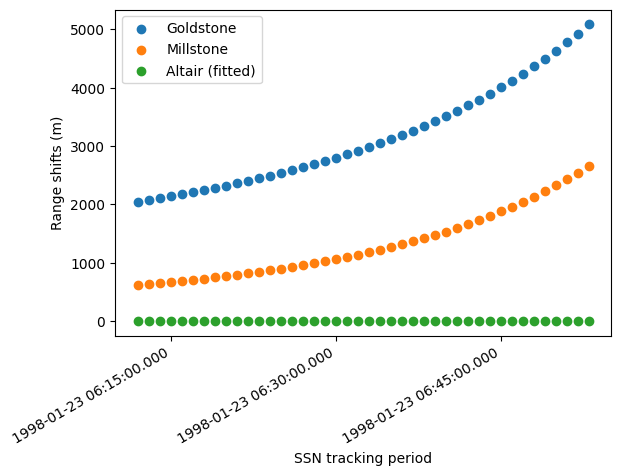

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Range shifts (m)')
    plt.scatter(ssn_epochs, dss25_shifts, label="Goldstone")
    plt.scatter(ssn_epochs, millstone_shifts, label="Millstone")
    plt.scatter(ssn_epochs, altair_shifts, label="Altair (fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()

In [11]:
altair_doppler = []
millstone_doppler = []
dss25_doppler = []

for o in ssn_offsets:
    e = ssn_start + o*u.s
    ref_rv = near_ssn_ref_ephem.rv(e)
    sim_rv = sim_goldstone_ephem.rv(e)

    ref_r, ref_rr, ref_ra = ssrAltair.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = ssrAltair.range_and_rate(sim_rv, e)
    altair_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

    ref_r, ref_rr, ref_ra = ssrMillstone.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = ssrMillstone.range_and_rate(sim_rv, e)
    millstone_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

    ref_r, ref_rr, ref_ra = dss25.range_rate_accel(ref_rv, e)
    ref_meas_rr = ref_rr + ref_ra*ref_r/const.c
    sim_r, sim_rr = dss25.range_and_rate(sim_rv, e)
    dss25_doppler.append((sim_rr - ref_meas_rr).to_value(u.m/u.s))

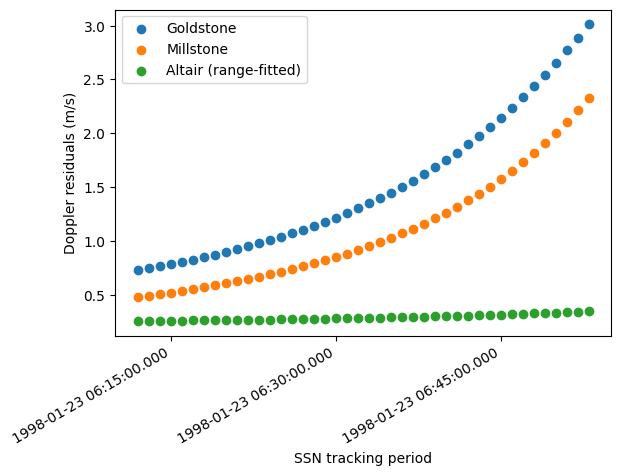

In [12]:
from astropy import visualization
with visualization.time_support():
    plt.xlabel('SSN tracking period')
    plt.ylabel('Doppler residuals (m/s)')
    plt.scatter(ssn_epochs, dss25_doppler, label="Goldstone")
    plt.scatter(ssn_epochs, millstone_doppler, label="Millstone")
    plt.scatter(ssn_epochs, altair_doppler, label="Altair (range-fitted)")
    plt.legend(loc="best")
    plt.gcf().autofmt_xdate()